
 # Dataset:

## user related features
cms_segid: 0-96

cms_group_id: 0-12

age: 0-6

pvalue: 1,2,3

shopping_level:1,2,3

occupation: 1,0

## from ad (onsite features)
cate_id: 6725

adgroup_id: 827009

brand:98772

customer:252841

price: float

In [1]:
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
#import pandas_profiling 
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import itertools
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

#!pip install matplotlib
import matplotlib


In [2]:
if torch.cuda.is_available():
    device = "cuda"
    #torch.set_default_tensor_type("torch.cuda.FloatTensor")
    print("USING CUDA")
else:
    device = "cpu"
    print("USING CPU")

# sending model to cuda has error (not sure why)
#device = 'cpu'

USING CUDA


In [6]:
def load_taobao_df():
    ad = "ad_feature.csv"
    ad_feature_df =  pd.read_csv(ad)

    raw_sample = "raw_sample.csv"
    raw_sample_df = pd.read_csv(raw_sample)

    user = "user_profile.csv"
    user_profile_df = pd.read_csv(user)

    # memory optimize for ad feature dataframe
    optimized_gl = raw_sample_df.copy()

    gl_int = raw_sample_df.select_dtypes(include=['int'])
    converted_int = gl_int.apply(pd.to_numeric,downcast='unsigned')
    optimized_gl[converted_int.columns] = converted_int


    gl_obj = raw_sample_df.select_dtypes(include=['object']).copy()
    converted_obj = pd.DataFrame()
    for col in gl_obj.columns:
        num_unique_values = len(gl_obj[col].unique())
        num_total_values = len(gl_obj[col])
        if num_unique_values / num_total_values < 0.5:
            converted_obj.loc[:,col] = gl_obj[col].astype('category')
        else:
            converted_obj.loc[:,col] = gl_obj[col]
    optimized_gl[converted_obj.columns] = converted_obj
    raw_sample_df = optimized_gl.copy()
    raw_sample_df_new = raw_sample_df.rename(columns = {"user": "userid"})
    optimized_g2 = ad_feature_df.copy()
    g2_int = ad_feature_df.select_dtypes(include=['int'])
    converted_int = g2_int.apply(pd.to_numeric,downcast='unsigned')
    optimized_g2[converted_int.columns] = converted_int

    g2_float = ad_feature_df.select_dtypes(include=['float'])
    converted_float = g2_float.apply(pd.to_numeric,downcast='float')
    optimized_g2[converted_float.columns] = converted_float

    optimized_g3 = user_profile_df.copy()

    g3_int = user_profile_df.select_dtypes(include=['int'])
    converted_int = g3_int.apply(pd.to_numeric,downcast='unsigned')
    optimized_g3[converted_int.columns] = converted_int

    g3_float = user_profile_df.select_dtypes(include=['float'])
    converted_float = g3_float.apply(pd.to_numeric,downcast='float')
    optimized_g3[converted_float.columns] = converted_float

    # combine 3 tables
    df1 = raw_sample_df_new.merge(optimized_g3, on="userid")
    final_df = df1.merge(optimized_g2, on="adgroup_id")

    final_df['pvalue_level'] = final_df['pvalue_level'].fillna(2, )
    final_df['final_gender_code'] = final_df['final_gender_code'].fillna(1, )
    final_df['age_level'] = final_df['age_level'].fillna(3, )
    final_df['shopping_level'] = final_df['shopping_level'].fillna(2, )
    final_df['occupation'] = final_df['occupation'].fillna(0, )
    final_df['brand'] = final_df['brand'].fillna(0, )
    final_df['customer'] = final_df['customer'].fillna(0, )
    final_df['cms_group_id'] = final_df['cms_group_id'].fillna(13, )

    final_df['pvalue_level'] -= 1
    final_df['shopping_level'] -= 1
    final_df = final_df.astype({"cms_segid": int, 
                                "cms_group_id": int, 
                                'clk': float, 
                                'adgroup_id': int, 
                                'final_gender_code':int,
                                'age_level':int,
                                'pvalue_level':int,
                                'shopping_level':int,
                                'occupation':int,
                                'cate_id':int,
                                'customer':int,
                                'brand':int}
                                )

    return final_df

In [7]:
tb_df = load_taobao_df()

## Analysis of Datasets

In [5]:
# checking the dataset
# how many label 1 
# so that the dataset is very unbalanced
sum(tb_df['clk'])/len(tb_df)

0.051320095719300095

In [6]:
tb_df.head(3)

,userid,time_stamp,adgroup_id,pid,nonclk,clk,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level,cate_id,campaign_id,customer,brand,price
0,581738,1494137644,1,430548_1007,1,0.0,0,8,1,2,1,2,0,NaN,9025,108570,1337,20169,17.0
1,581738,1494130330,6029,430548_1007,1,0.0,0,8,1,2,1,2,0,NaN,7008,415604,70200,64668,11800.0
2,439866,1494288737,6029,430548_1007,1,0.0,91,11,1,5,1,2,0,2.0,7008,415604,70200,64668,11800.0


[2 5 4 3 1 6 0]
max ratio: 0.30258829254435826


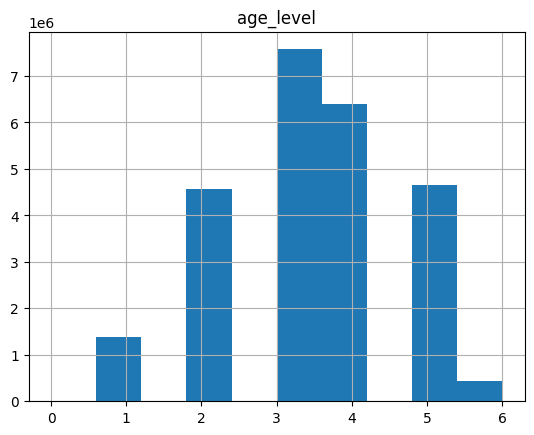

In [7]:
tb_df.hist(column='age_level')
print(tb_df['age_level'].unique())
ratio = len(tb_df[tb_df['age_level'] == 3])/len(tb_df)
print('max ratio:', ratio)

[ 8 11 10  9  7 12  5  4  2  6  3  1  0]
max ratio: 0.22764976516649296


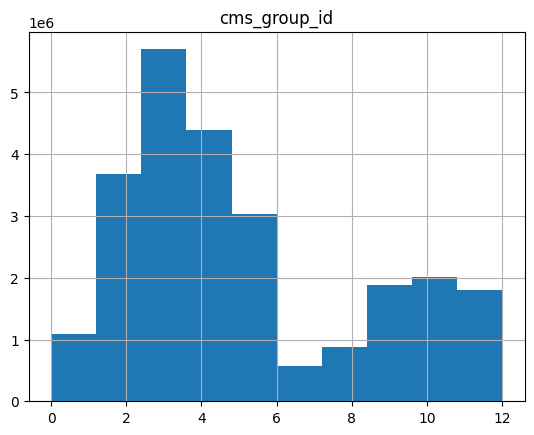

In [8]:
tb_df.hist(column='cms_group_id')
print(tb_df['cms_group_id'].unique())
ratio = len(tb_df[tb_df['cms_group_id'] == 3])/len(tb_df)
print('max ratio:', ratio)

[1 0 2]
max ratio: 0.7996814550548185


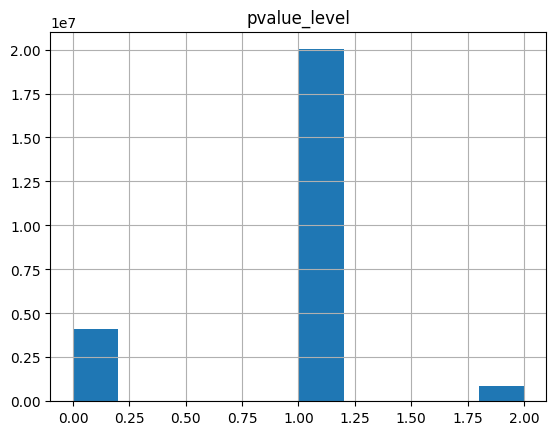

In [9]:
tb_df.hist(column='pvalue_level')
print(tb_df['pvalue_level'].unique())
ratio = len(tb_df[tb_df['pvalue_level'] == 1])/len(tb_df)
print('max ratio:', ratio)

[2 1 0]
max ratio: 0.8516571788376366


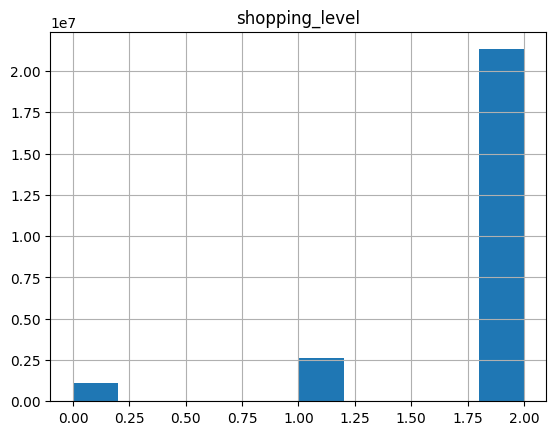

In [10]:
tb_df.hist(column='shopping_level')
print(tb_df['shopping_level'].unique())
ratio = len(tb_df[tb_df['shopping_level'] == 2])/len(tb_df)
print('max ratio:', ratio)

[0 1]
max ratio: 0.9455062409519033


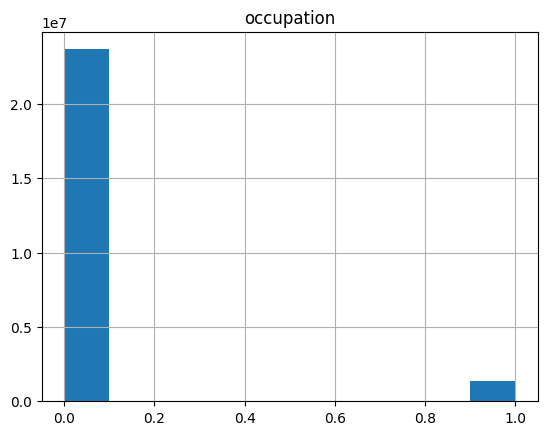

In [11]:
tb_df.hist(column='occupation')
print(tb_df['occupation'].unique())
ratio = len(tb_df[tb_df['occupation'] == 0])/len(tb_df)
print('max ratio:', ratio)

## preparing dataset

In [8]:
# can we get a balanced dataset, by taking the same number of positive label and negative labels
# so that training would be ok for now
df_1 = tb_df[tb_df['clk'] == 1]
df_0 = tb_df[tb_df['clk'] == 0]
print(len(df_1))
print(len(df_0))
frames = [df_1, df_0[:1284513]]
df = pd.concat(frames)
print(len(df))
df = df.sample(frac=1)
tb_train = df[:50000]
tb_test = df[-10000:]
tb_test = tb_test.reset_index()
tb_train = tb_train.reset_index()

1284513
23744922
2569026


In [13]:
# train test split
#tb_train = tb_df[:2252650] # 90% for training
#tb_test = tb_df[2252650:]
#tb_test = tb_test.reset_index()

# cpu slow, so just test a few 
#tb_train = tb_df[:50000] # 90% for training
#tb_test = tb_df[-10000:]
#tb_test = tb_test.reset_index()

## Model: server_arch and client_arch

In [6]:
class Dataset_split(Dataset):
    def __init__(self, X, emb_cols, server_continuous_cols, non_emb_cols):
        X = X.copy()
        self.server_categorical = X.loc[:,emb_cols].copy().values.astype(np.int64) #categorical columns
        self.client = X.reindex(columns = non_emb_cols).values.astype(np.float32)
        self.server_continuous = X.reindex(columns = server_continuous_cols).values.astype(np.float32)
        self.y = X['clk']
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        #return self.server_categorical[idx], self.server_continuous[idx], self.client[idx], self.y[idx]

        return {'server_categorical': self.server_categorical[idx],
                'server_continuous': self.server_continuous[idx],
                'client': self.client[idx],
                'label': self.y[idx]}

Create 2 parts of model: server_arch and client_arch like in FSL project. 

The server_arch takes in 2 types of input: categorical and continuous. The categorical input will go through the embedding layer first and then concatenate with the continuous input. There is only 1 continuous features 'price' in this dataset.

The client_arch takes in only one input. In our case, all 5 features are categorical, which are user related and we are going to reconstructed these 5 features. 

In [7]:
# server side arch
class server_arch(nn.Module):
    def __init__(self, embedding_sizes, n_cont):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings) #length of all embeddings combined
        self.n_emb, self.n_cont = 250, n_cont
        self.emb_drop = nn.Dropout(0.6)
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 64)
        

    def forward(self, x_server_categorical,x_server_continuous):
        x = [e(x_server_categorical[:,i]) for i,e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = torch.cat([x,x_server_continuous], 1)
        x = self.emb_drop(x)
        x = F.relu(self.lin1(x))
        return x

class client_arch(nn.Module):
    def __init__(self, n_server_output, n_client_input):
        super().__init__()
        self.n_server_output = n_server_output
        self.n_client_input = n_client_input
        self.lin1 = nn.Linear(self.n_server_output + self.n_client_input, 32)
        self.lin2 = nn.Linear(32, 32)
        self.lin3 = nn.Linear(32, 1)
        #self.bn1 = nn.BatchNorm1d(self.n_cont)
        #self.bn2 = nn.BatchNorm1d(64)
        #self.bn3 = nn.BatchNorm1d(32)
        #self.emb_drop = nn.Dropout(0.6)
        #self.drops = nn.Dropout(0.3)
        

    def forward(self, server_output, x_client):
        cut_layer = torch.cat([server_output, x_client], 1)
        x = F.relu(self.lin1(cut_layer))
        #x = self.drops(x)
        #x = self.bn2(x)
        x = F.relu(self.lin2(x))
        #x = self.drops(x)
        #x = self.bn3(x)
        x = torch.sigmoid(self.lin3(x))
        return x

    def set_model_gradients(self, gradient):
        params = list(self.parameters())
        for p, grad in zip(params, gradient):
            p.grad = grad.clone()

    def backward(self, cut_node, output, target, loss_fn, update_model_grad=True):
        loss = loss_fn(output, target)
        params = list(self.parameters())
                
        # gradients dE/dw_n
        de_dw = torch.autograd.grad(
            [loss],
            params,
            retain_graph = True,
        )

        if update_model_grad:
            self.set_model_gradients(de_dw)


        de_dx = torch.autograd.grad(
            [loss],
            cut_node,
            retain_graph = True,
        )

        return de_dw, de_dx


## fit() and validate() function

In [8]:
def validate_split(server_model, client_model, loss_fn, test_dataloader, device):
    server_model.eval()
    client_model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    y_proba_list = []
    y_true_list = []
    y_pred_list = []
    for batch in test_dataloader:
        for key, value in batch.items():
                batch[key] = batch[key].to(device)

        y = batch['label'].unsqueeze(1).to(torch.float32)

        current_batch_size = y.shape[0]

        server_output = server_model(batch['server_categorical'], batch['server_continuous'])
        out = client_model(server_output, batch['client'])
        
        y_proba_list.extend(out.detach().cpu().numpy())
        y_true_list.extend(y.detach().cpu().numpy())

        loss = loss_fn(out, y)
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.round(out).squeeze()

        y_pred_list.extend(pred.detach().cpu().numpy())
        y = y.squeeze()
        correct += (pred == y).sum()

        

    print("test loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))
    auc = metrics.average_precision_score(y_true_list,y_proba_list)
    print("AUC=",auc)
    conf_matrix = metrics.confusion_matrix(y_true_list,y_pred_list)
    print('confusion matrix=',conf_matrix)
    return sum_loss/total, correct/total

In [9]:
# build training loop that for separate model
def one_round_split_train(server_model, client_model, server_opt, client_opt, batch , loss_fn):
    # zero all optimizers
    server_opt.zero_grad()
    client_opt.zero_grad()

    server_output = server_model(batch['server_categorical'],batch['server_continuous'])
    client_output = client_model(server_output,batch['client'])

    label = batch['label'].unsqueeze(1).to(torch.float32)

    loss = loss_fn(client_output, label)

    # backward
    dw, dx = client_model.backward(server_output, client_output, label,loss_fn, update_model_grad=True)

    server_output.backward(dx)
    server_opt.step()
    client_opt.step()
    return loss, client_output     

In [10]:
def fit(server_model, client_model, trainloader, testloader, epochs, lr= 1, momentum=0):
    loss_fn = nn.BCELoss()
    server_opt = torch.optim.SGD(server_model.parameters(),lr=lr, momentum = momentum)
    client_opt = torch.optim.SGD(client_model.parameters(),lr=lr, momentum = momentum)

    batch_idx = 0
    total_loss = 0
    total = 0
    print('starting fiting')
    for e in range(0,epochs):
        print('epoch', e)
        for batch in trainloader:
            #batch_idx += 1
            #print(batch_idx)
            for key, value in batch.items():
                batch[key] = batch[key].to(device)

            loss, output = one_round_split_train(server_model, client_model, server_opt, client_opt, batch, loss_fn)
            total_loss += loss
            total += batch['label'].shape[0]

            #if batch_idx % 500 == 0:
        val_loss, val_acc = validate_split(server_model, client_model, loss_fn, testloader, device)

## Training

In [11]:
#creating train and valid datasets
client_cols = ['cms_group_id','age_level','pvalue_level','shopping_level','occupation']
embedding_cols = ['adgroup_id','cate_id','customer','brand','cms_segid'] # cms_segid is from user_related, should we change it???
continuous = ['price']
trainset = Dataset_split(tb_train, embedding_cols, continuous, client_cols)
testset = Dataset_split(tb_test, embedding_cols, continuous, client_cols)
print(len(trainset))
print(len(testset))

50000
10000


In [12]:
batch_size = 1024
train_dataloader = DataLoader(trainset, batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size,shuffle=True)

# fitting
epochs = 10
lr = 0.05
momentum = 0.0
device = 'cpu'
embedded_cols = {'adgroup_id':846811,
            'cate_id': 12960,
            'customer': 255875,
            'brand': 461497,
            'cms_segid': 96}
embedding_sizes = [(846811+1, 50), (12960+1,50), (255875+1,50),(461497+1,50),(96+1,50)]
client_cols = ['cms_group_id','age_level','pvalue_level','shopping_level','occupation']
server_continous = ['price']
server_model = server_arch(embedding_sizes, 1).to(device)
client_model = client_arch(64, len(client_cols)).to(device)

fit(server_model, client_model,train_dataloader, test_dataloader, epochs, lr, momentum)

starting fiting
epoch 0
test loss 0.691 and accuracy 0.528
AUC= 0.604424928058476
confusion matrix= [[4831  221]
 [4495  453]]
epoch 1
test loss 0.696 and accuracy 0.583
AUC= 0.6194241099276111
confusion matrix= [[4228  824]
 [3346 1602]]
epoch 2
test loss 0.695 and accuracy 0.602
AUC= 0.6169324951632099
confusion matrix= [[3771 1281]
 [2703 2245]]
epoch 3
test loss 0.693 and accuracy 0.598
AUC= 0.6146272446519586
confusion matrix= [[3719 1333]
 [2686 2262]]
epoch 4
test loss 0.692 and accuracy 0.581
AUC= 0.6089247766718265
confusion matrix= [[3785 1267]
 [2920 2028]]
epoch 5
test loss 0.692 and accuracy 0.564
AUC= 0.600910191597241
confusion matrix= [[3939 1113]
 [3245 1703]]
epoch 6
test loss 0.690 and accuracy 0.602
AUC= 0.6174211709214208
confusion matrix= [[3809 1243]
 [2740 2208]]
epoch 7
test loss 0.689 and accuracy 0.595
AUC= 0.6145910805295248
confusion matrix= [[3877 1175]
 [2876 2072]]
epoch 8
test loss 0.688 and accuracy 0.583
AUC= 0.6171147082681414
confusion matrix= [[392

## Attack

In [21]:
class Reconstruct_taobao:
    def __init__(self, server_model, client_model):
        self.server_model = server_model
        self.client_model = client_model

    def reconstruct(
        self,
        cluster_combination_list,
        server_output,
        label,
        dx_original,
        cate_original,
        offsite_feature_shape=5,
    ):
        self.client_model.eval()
        #cluster_combination_list = self.get_cluster_combination(cluster_centers)
        dx_diff_list = []

        for cate_try in cluster_combination_list:
            # forward pass the client side model
            # use the other data, but the reconstructed cluster center to be offsite feature to see if dx match.
            cate_try = torch.tensor(cate_try).type(torch.float32)
            cate_try = cate_try.unsqueeze(0)
            
            client_output_recon = client_model(server_output,cate_try)

            # backward pass the client side model
            # get the gradient and compare with dx and store
            
            _, dx_recon = client_model.backward(
                            server_output, 
                            client_output_recon, 
                            label,
                            loss_fn,
                            update_model_grad=False)

            dx_recon = dx_recon[0]
            # calculate the distance between dx and dx_original
            # to get the smallest distance as the reconstructed center
            dx_diff = self.get_dist_between_dx(dx_recon, dx_original)
            dx_diff_list.append(dx_diff.clone().detach())

        # output the lowest distance cluster center
        minpos = dx_diff_list.index(min(dx_diff_list))
        reconstruct_output = cluster_combination_list[minpos]

        # check for accuracy
        # assert center_original in cluster_combination_list
        cate_original = cate_original[0].int()

        reconstruct_output = torch.tensor(reconstruct_output)

        # get the acc for each features
        acc = [int(i == j) for i, j in zip(reconstruct_output, cate_original)]
        
        return acc

    def get_dist_between_dx(self, dx_recon, dx_original):
        pdist = torch.nn.PairwiseDistance(p=2)
        pdistloss = torch.mean(pdist(dx_recon, dx_original))
        return pdistloss

In [22]:
# start doing the attack
# testloader too to have batch 1
def attack_cluster(testloader, cluster_combination_list, server_model, client_model, loss_fn, num_features=5):
    stats_output= {}
    acc_total = [0 for i in range(num_features)]
    num_samples = 0
    # initiaze the reconstruct machine
    recon_machine = Reconstruct_taobao(
        server_model = server_model,
        client_model = client_model
    )

    server_model.eval()
    client_model.eval()

    for batch_idx, batch in enumerate(testloader):
        num_samples += 1

        cate_original = batch['client']
        
        #print('cate original', cate_original.size())
        label = batch['label'].unsqueeze(1).to(torch.float32)

        server_output_original = server_model(batch['server_categorical'],batch['server_continuous'])
        client_output_original = client_model(server_output_original,batch['client'])

        _, dx_original = client_model.backward(
                server_output_original, 
                client_output_original, 
                label,
                loss_fn, 
                update_model_grad=False)
        dx_original = dx_original[0]

        # doing the attack
        acc = recon_machine.reconstruct(
                    cluster_combination_list,
                    server_output_original,
                    label,
                    dx_original,
                    cate_original,
        )
        
        acc_total = [sum(i) for i in zip(acc_total, acc)]  # without proba, cannot calculate the AUC # average precision recall, do we need proba?. otherwise can only look at confusion matrics

        if batch_idx % 500 == 0:
            print('batch idx', batch_idx)
            print('acc_total', acc_total)
            print('acc per features', [x / num_samples for x in acc_total])
            print('acc average over features', sum(acc_total)/(num_samples*num_features))
        
    stats_output['acc_per_features'] = [x / num_samples for x in acc_total]
    stats_output['acc_avg'] = sum(acc_total)/(num_samples*num_features)
    print(stats_output['acc_avg'])
    return stats_output


In [23]:
test_dataloader_attack = DataLoader(testset, batch_size=1,shuffle=False)
loss_fn = nn.BCELoss()
# features can be attacked
feature_offsite = ['cms_group_id','age_level','pvalue_level','shopping_level','occupation']
offsite_category = [13, 7, 3, 3, 2] 
cluster = []

# create a combination
for i in range(len(offsite_category)):
    temp = [j for j in range(offsite_category[i])]
    cluster.append(temp)

cluster_combination_list = list(itertools.product(*cluster))
print('total number of diffierent combination of category:', len(cluster_combination_list))

total number of diffierent combination of category: 1638


In [24]:
# run the attack
output = attack_cluster(test_dataloader_attack, cluster_combination_list, server_model, client_model, loss_fn)

batch idx 0
acc_total [1, 1, 1, 1, 1]
acc per features [1.0, 1.0, 1.0, 1.0, 1.0]
acc average over features 1.0


KeyboardInterrupt: 

## Baselines
Using server's features to do the attack, rather than the gradient (dx). 
Do the kmeans(server_features), because it has a lot of categoris. Then use these kmeans to predict the on-device user_related features.

use the KNN method to predict the offsite features.

In [9]:
def knn_original(tb_train, tb_test, server_cols, offsite_cols, n_neighbors):
    # doing the knn prediction to recon the offsite features
    # using the original server_features

    X_train = tb_train.loc[:,server_cols].copy().values.astype(np.int64) 
    y_train = tb_train.loc[:,offsite_cols].copy().values.astype(np.int64)
    X_test = tb_test.loc[:,server_cols].copy().values.astype(np.int64) 
    y_test = tb_test.loc[:,offsite_cols].copy().values.astype(np.int64)
    #X_train, X_test, y_train, y_test = train_test_split(server_data, offsite_data, test_size=0.2)

    for i in range(len(offsite_cols)):
        train_y = y_train[:,i]
        test_y = y_test[:,i]
        knn =  KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train,train_y)
        y_pred = knn.predict(X_test)
        accuracy = metrics.accuracy_score(test_y, y_pred)
        print( offsite_cols[i])
        print('acc=', accuracy)
        if offsite_cols[i] == 'occupation':
            auc = metrics.average_precision_score(test_y, knn.predict_proba(X_test)[:, 1])
            f1_socre = metrics.f1_score(test_y, knn.predict(X_test))
        else:
            auc = metrics.roc_auc_score(test_y, knn.predict_proba(X_test), multi_class='ovr')
            f1_socre = metrics.f1_score(test_y, knn.predict(X_test), average='macro')
        print('auc=',auc)
        print('f1_score=',f1_socre)


In [10]:
server_cols = ['adgroup_id','cate_id','customer','brand','cms_segid']
feature_offsite = ['cms_group_id','age_level','pvalue_level','shopping_level','occupation']
knn_original(tb_train = tb_train, tb_test = tb_test, server_cols=server_cols, offsite_cols=feature_offsite, n_neighbors=30)

cms_group_id
acc= 0.3139
auc= 0.6170887071736147
f1_score= 0.12332117185248576
age_level
acc= 0.3724
auc= 0.6238305035324773
f1_score= 0.21481366801847362
pvalue_level
acc= 0.792
auc= 0.6593900040769846
f1_score= 0.37042055710833904
shopping_level
acc= 0.864
auc= 0.5981990481007261
f1_score= 0.3090128755364807
occupation
acc= 0.9461
auc= 0.20000350099131414
f1_score= 0.14308426073131955


In [9]:
# then kmeans the server features first, then do the knn
def knn_kmeans(tb_train, tb_test, server_cols, offsite_cols, n_cluster_kmeans=100, n_neighbors=30):
    # doing the kmeans of server features first

    X_train = tb_train.loc[:,server_cols].copy().values.astype(np.int64) 
    y_train = tb_train.loc[:,offsite_cols].copy().values.astype(np.int64)
    X_test = tb_test.loc[:,server_cols].copy().values.astype(np.int64) 
    y_test = tb_test.loc[:,offsite_cols].copy().values.astype(np.int64)
    #X_train, X_test, y_train, y_test = train_test_split(server_data, offsite_data, test_size=0.2)
    kmeans = KMeans(n_clusters=n_cluster_kmeans) #takes 20min
    kmeans.fit(X_train)
    x_train_kmeans = kmeans.predict(X_train)
    x_test_kmeans = kmeans.predict(X_test)
    x_train_center = [kmeans.cluster_centers_[i] for i in x_train_kmeans]
    x_test_center = [kmeans.cluster_centers_[i] for i in x_test_kmeans]
    print('finish kmeans')

    #start knn
    for i in range(len(offsite_cols)):
        train_y = y_train[:,i]
        test_y = y_test[:,i]
        knn =  KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(x_train_center,train_y)
        y_pred = knn.predict(x_test_center)
        accuracy = metrics.accuracy_score(test_y, y_pred)
        print(offsite_cols[i])
        print('acc=', accuracy)
        if offsite_cols[i] == 'occupation':
            auc = metrics.average_precision_score(test_y, knn.predict_proba(X_test)[:, 1])
            f1_socre = metrics.f1_score(test_y, knn.predict(X_test))
        else:
            auc = metrics.roc_auc_score(test_y, knn.predict_proba(X_test), multi_class='ovr')
            f1_socre = metrics.f1_score(test_y, knn.predict(X_test), average='macro')
        print('auc=',auc)
        print('f1_score=',f1_socre)

In [11]:
server_cols = ['adgroup_id','cate_id','customer','brand','cms_segid']
feature_offsite = ['cms_group_id','age_level','pvalue_level','shopping_level','occupation']
knn_kmeans(tb_train = tb_train, tb_test = tb_test, server_cols=server_cols, offsite_cols=feature_offsite, n_cluster_kmeans=50, n_neighbors=30)

: 

: 

In [11]:
def knn_serveroutput(tb_train, tb_test, offsite_cols, server_model, n_neighbors=30):
    # doing the kmeans of server output
    # get the server output first
    embedding_cols = ['adgroup_id','cate_id','customer','brand','cms_segid'] # cms_segid is from user_related, should we change it???
    continuous = ['price']
    trainset = Dataset_split(tb_train, embedding_cols, continuous, offsite_cols)
    testset = Dataset_split(tb_test, embedding_cols, continuous, offsite_cols)
    train_dataloader = DataLoader(trainset, batch_size=32,shuffle=False)
    test_dataloader = DataLoader(testset, batch_size=32,shuffle=False)
    server_model.eval()
    server_output_train = None
    server_output_test = None
    y_train = None
    y_test = None

    for batch in train_dataloader:
        if server_output_train is None:
            server_output_train = server_model(batch['server_categorical'],batch['server_continuous']).detach().numpy()
            y_train = batch['client'].detach().numpy()
        else:
            out = server_model(batch['server_categorical'],batch['server_continuous']).detach().numpy()
            server_output_train = np.concatenate((server_output_train,out), axis = 0)
            y_train = np.concatenate((y_train,batch['client'].detach().numpy() ), axis = 0)

    for batch in test_dataloader:
        if server_output_test is None:
            server_output_test = server_model(batch['server_categorical'],batch['server_continuous']).detach().numpy()
            y_test = batch['client'].detach().numpy()
        else:
            out = server_model(batch['server_categorical'],batch['server_continuous']).detach().numpy()
            server_output_test = np.concatenate((server_output_test,out), axis = 0)
            y_test = np.concatenate((y_test,batch['client'].detach().numpy() ), axis = 0)

    #run knn on server_output 
    for i in range(len(offsite_cols)):
        train_y = y_train[:,i]
        test_y = y_test[:,i]
        knn =  KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(server_output_train,train_y)
        y_pred = knn.predict(server_output_test)
        accuracy = metrics.accuracy_score(test_y, y_pred)
        print(offsite_cols[i])
        print('acc=',accuracy)
        print(accuracy)
        if offsite_cols[i] == 'occupation':
            auc = metrics.average_precision_score(test_y, knn.predict_proba(server_output_test)[:, 1])
            f1_socre = metrics.f1_score(test_y, knn.predict(server_output_test))
        else:
            auc = metrics.roc_auc_score(test_y, knn.predict_proba(server_output_test), multi_class='ovr')
            f1_socre = metrics.f1_score(test_y, knn.predict(server_output_test), average='macro')
        print('auc=',auc)
        print('f1_score=',f1_socre)
        


In [12]:
embedding_sizes = [(846811+1, 50), (12960+1,50), (255875+1,50),(461497+1,50),(96+1,50)]
server_model = server_arch(embedding_sizes, 1).to('cpu')
feature_offsite = ['cms_group_id','age_level','pvalue_level','shopping_level','occupation']
knn_serveroutput(tb_train = tb_train, tb_test = tb_test, offsite_cols = feature_offsite, server_model = server_model, n_neighbors=30)

NameError: name 'server_arch' is not defined

## FSL code

In [ ]:
class FSL_taobao:
    def __init__(self, batch_size, device, lr, momentum):
        self.device = device
        self.batch_size = batch_size
        self.client_model = client_arch(64, len(client_cols)).to(device)
        self.server_model = server_arch(embedding_sizes, 1).to(device)
        self.loss_fn = nn.BCELoss()
        self.opt_server = [torch.optim.SGD(self.server_model.parameters(),lr=lr, momentum = momentum)]
        self.opt_client = torch.optim.SGD(self.client_model.parameters(),lr=lr, momentum = momentum)
        self.opts = self.opt_server + [self.opt_client]
    
    
    def emulatedFL_clients(self, server_output, batch, emulated_user_samples):
        # this emulate a series of FL clients
        # (1) it splits the original batch into smaller sub-batches
        # (2) it forwards pass these smaller batches intot he client model
        # (3) it calculates the return the grad but didnt update the model
        # (4) it returns a list one per clients

        num_users = len(server_output) // emulated_user_samples

        # forward pass for each client
        client_output = []
        client_dw = []
        client_dx = []
        num_samples = []

        for u in range(num_users):
            s = u * emulated_user_samples # start point for user data
            e = (u+1) * emulated_user_samples # end point for user data
            server_out_to_client = server_output[s:e]
            label = batch['label'][s:e].unsqueeze(1).to(torch.float32)
            client_input = batch['client'][s:e]
            n_s = len(label)
            
            # for each client, zero the grad
            self.opt_client.zero_grad()
            out = self.client_model(server_out_to_client,client_input)
            dw, dx = self.client_model.backward(server_out_to_client, out, label, self.loss_fn, update_model_grad=True)

            client_output.append(out)
            client_dw.append(dw)
            client_dx.append(dx[0])
            num_samples.append(n_s)
        return client_output, client_dw, client_dx, num_samples

    def one_round_emulatedFL(self, batch, emulated_user_samples = 16):
        self.server_model.train()
        self.client_model.train()
        for o in self.opts:
            o.zero_grad()
        
        server_output = self.server_model(batch['server_categorical'],batch['server_continuous'])
        client_output, client_dw, client_dx, num_samples = self.emulatedFL_clients(
            server_output, batch, emulated_user_samples=emulated_user_samples
        )
        
        # calculate the average client dw grad
        average_dw = [torch.mean(torch.stack(p), dim = 0) for p in zip(*client_dw)]
        self.client_model.set_model_gradients(average_dw)

        # dont aggregate dx
        all_clients_dx = torch.cat(client_dx)
        server_output.backward(all_clients_dx)

        # step all opt
        for o in self.opts:
            o.step()
        
        all_out = torch.cat(client_output)

        # return values to print stats
        labels = batch['label'].unsqueeze(1).to(torch.float32)
        loss = self.loss_fn(all_out, labels)
        return loss, all_out

    def validate_split(self, test_dataloader):
        self.server_model.eval()
        self.client_model.eval()
        total = 0
        sum_loss = 0
        correct = 0
        y_proba_list = []
        y_true_list = []
        y_pred_list = []
        for batch in test_dataloader:
            for key, value in batch.items():
                    batch[key] = batch[key].to(self.device)

            y = batch['label'].unsqueeze(1).to(torch.float32)

            current_batch_size = y.shape[0]

            server_output = self.server_model(batch['server_categorical'], batch['server_continuous'])
            out = self.client_model(server_output, batch['client'])
            
            y_proba_list.extend(out.detach().cpu().numpy())
            y_true_list.extend(y.detach().cpu().numpy())

            loss = self.loss_fn(out, y)
            sum_loss += current_batch_size*(loss.item())
            total += current_batch_size
            pred = torch.round(out).squeeze()

            y_pred_list.extend(pred.detach().cpu().numpy())
            y = y.squeeze()
            correct += (pred == y).sum()

            
        print("test loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))
        auc = metrics.average_precision_score(y_true_list,y_proba_list)
        print("AUC= ", auc)
        conf_matrix = metrics.confusion_matrix(y_true_list,y_pred_list)
        print('confusion matrix=')
        print(conf_matrix)
        return sum_loss/total, correct/total
    
    def fit(self,trainset, testset, epochs):
        print('fitting FSL')
        train_dataloader = DataLoader(trainset, batch_size=self.batch_size,shuffle=True)
        test_dataloader = DataLoader(testset, batch_size=self.batch_size,shuffle=False)     

        for e in range(epochs):
            print('_______epoch:',e)
            for batch in train_dataloader:
                for key, _ in batch.items():
                    batch[key] = batch[key].to(self.device)
                
                loss, out = self.one_round_emulatedFL(batch)
            
            loss_val, acc_val = self.validate_split(test_dataloader)
        #loss_val, acc_val = self.validate_split(test_dataloader)
        return []

    def attack_cluster(self, testset, num_features=5):
        dataloader = DataLoader(testset, batch_size=1, shuffle=False)

        # features can be attacked
        feature_offsite = ['cms_group_id','age_level','pvalue_level','shopping_level','occupation']
        offsite_category = [13, 7, 3, 3, 2] 
        cluster = []

        # create a combination
        for i in range(len(offsite_category)):
            temp = [j for j in range(offsite_category[i])]
            cluster.append(temp)

        cluster_combination_list = list(itertools.product(*cluster))
        print('total number of diffierent combination of category:', len(cluster_combination_list))
        
        stats_output= {}
        acc_total = [0 for i in range(num_features)]
        num_samples = 0
        # initiaze the reconstruct machine
        recon_machine = Reconstruct_taobao(
            server_model = self.server_model,
            client_model = self.client_model
        )

        self.server_model.eval()
        self.client_model.eval()

        for batch_idx, batch in enumerate(dataloader):
            num_samples += 1
            cate_original = batch['client']
            
            #print('cate original', cate_original.size())
            label = batch['label'].unsqueeze(1).to(torch.float32)

            server_output_original = self.server_model(batch['server_categorical'],batch['server_continuous'])
            client_output_original = self.client_model(server_output_original,batch['client'])

            dw_original, dx_original = self.client_model.backward(
                    server_output_original, 
                    client_output_original, 
                    label,
                    self.loss_fn, 
                    update_model_grad=False)
            dx_original = dx_original[0]

            # doing the attack
            acc = recon_machine.reconstruct(
                        cluster_combination_list,
                        server_output_original,
                        label,
                        dx_original,
                        cate_original,
            )
            
            acc_total = [sum(i) for i in zip(acc_total, acc)]  

            if batch_idx % 500 == 0:
                print('batch idx', batch_idx)
                print('acc_total', acc_total)
                print('acc per features', [x / num_samples for x in acc_total])
                print('acc average over features', sum(acc_total)/(num_samples*num_features))
            
        stats_output['acc_per_features'] = [x / num_samples for x in acc_total]
        stats_output['acc_avg'] = sum(acc_total)/(num_samples*num_features)
        print(stats_output['acc_avg'])
        return stats_output

In [ ]:
def run_fsl(batch_size, device, lr, momentum, epochs, if_attack=True):
    #tb_df = load_taobao_df() #should include here, but might be slow
    
    trainset = Dataset_split(tb_train, embedding_cols, continuous, client_cols)
    testset = Dataset_split(tb_test, embedding_cols, continuous, client_cols)
    trainer = FSL_taobao(batch_size=batch_size, device=device, lr = lr, momentum= momentum)
    
    # fit 
    res = trainer.fit(trainset, testset, epochs = epochs)
    
    # doing the attack
    if if_attack:
        print('starting attack')
        attack_output = trainer.attack_cluster(testset)

In [ ]:
batch_size = 1024 # should be multiple of 16, since each clients has 16 samples
lr = 0.01
momentum = 0.0
epochs = 5
device = device 

run_fsl(batch_size,device, lr, momentum, epochs, if_attack=True)

NameError: name 'device' is not defined